In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def getBuildingName(inputFilePath):
    return inputFilePath.split('/')[-1].split('_')[0]

In [3]:
def getOOFRmse(OOF_predsFile):
    OOFRmse = np.sqrt(np.square(OOF_predsFile['x_preds'] - OOF_predsFile['x_tgt']) + \
                      np.square(OOF_predsFile['y_preds'] - OOF_predsFile['y_tgt'])).mean()
    return OOFRmse

In [5]:
modelOutputDir = 'modelSaveDir/MLP_v7_Results'
modelWiFiOOF_files = sorted(glob.glob(f"{modelOutputDir}/*_OOF.pickle"))

In [6]:
buildingWifi_OOFPath = modelWiFiOOF_files[0]
buildingName = getBuildingName(buildingWifi_OOFPath)
print(f"buildingName = {buildingName}")
buildingWifi_OOF = pd.read_pickle(buildingWifi_OOFPath)
## print(f"OOF position rmse for building - {buildingName} is {getOOFRmse(buildingWifi_OOF)}")
buildingWifi_OOF = buildingWifi_OOF.sort_values(by=['path','timestamp']);
buildingWifi_OOF.head(3)

,timestamp,x_preds,y_preds,floor_preds,x_tgt,y_tgt,floor_tgt,path,fold
6876,1561368764807,110.867310,43.006271,-1.123863e-37,77.873085,37.509888,2.0,5d10a1669c50c70008fe8977,3
6877,1561368766804,111.554100,40.925041,-1.114239e-37,77.523071,35.998848,2.0,5d10a1669c50c70008fe8977,3
6878,1561368768807,116.016762,38.983437,-1.151458e-37,77.172005,34.483273,2.0,5d10a1669c50c70008fe8977,3


In [8]:
wayPointData_train = pd.read_pickle('wayPointData_train.pickle')
buildingWayPointData = wayPointData_train[wayPointData_train['building'] == buildingName]
print(f"buidling waypoint data shape = {buildingWayPointData.shape}")
buildingWayPointData = buildingWayPointData.sort_values(by=['path','timestamp']);
buildingWayPointData.head(3)

buidling waypoint data shape = (2491, 5)


,timestamp,x,y,path,building
1825,1561368762838,78.218193,38.999737,5d10a1669c50c70008fe8977,5a0546857ecc773753327266
1826,1561368774057,76.251839,30.510839,5d10a1669c50c70008fe8977,5a0546857ecc773753327266
1827,1561368793535,78.364815,10.530369,5d10a1669c50c70008fe8977,5a0546857ecc773753327266


In [15]:
wifiPaths = sorted(buildingWifi_OOF['path'].unique().tolist())
waypointPaths = sorted(buildingWayPointData['path'].unique().tolist())
commonPaths = sorted(list(set(wifiPaths).intersection(set(waypointPaths))))

In [40]:
interp_x = []
interp_y = []
x_groundTruth = []
y_groundTruth = []

for path in commonPaths:
    ## print(f"path = {path}")
    pathWifiData = buildingWifi_OOF[buildingWifi_OOF['path'] == path]
    pathWaypointData = buildingWayPointData[buildingWayPointData['path'] == path]

    ## interpolated waypoint data
    interpolatedXCoordinates = np.interp(pathWaypointData['timestamp'], pathWifiData['timestamp'], pathWifiData['x_preds'])
    interpolatedYCoordinates = np.interp(pathWaypointData['timestamp'], pathWifiData['timestamp'], pathWifiData['y_preds'])

    interp_x.append(interpolatedXCoordinates)
    interp_y.append(interpolatedYCoordinates)
    
    x_groundTruth.append(pathWaypointData['x'])
    y_groundTruth.append(pathWaypointData['y'])

interp_x = np.concatenate(interp_x, axis=0)
interp_y = np.concatenate(interp_y, axis=0)    
x_groundTruth = np.concatenate(x_groundTruth, axis=0)    
y_groundTruth = np.concatenate(y_groundTruth, axis=0)    

In [41]:
interp_x.shape, interp_y.shape, x_groundTruth.shape, y_groundTruth.shape

((2487,), (2487,), (2487,), (2487,))

In [43]:
np.sqrt(np.square(interp_x - x_groundTruth) + np.square(interp_y - y_groundTruth)).mean()

8.908190218568878

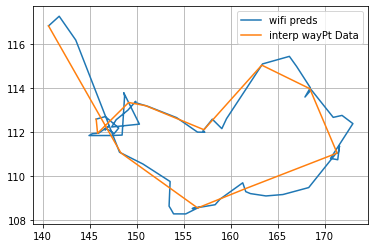

In [33]:
## plt.plot(pathWaypointData['x'], pathWaypointData['y'], label='waypoint Data')
plt.plot(pathWifiData['x_preds'], pathWifiData['y_preds'], label='wifi preds')
plt.plot(interpolatedXCoordinates, interpolatedYCoordinates, label='interp wayPt Data')
plt.legend()
plt.grid(True)
plt.show()